# Tutorial 2: Kernel2D

In [1]:
import matplotlib.pyplot as plt
import torch
from spectpsftoolbox.kernel2d import NGonKernel2D, FunctionalKernel2D
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2D kernels work similar to 1D kernels in `spectpsftoolbox`. They can be expressed as

$$f(x,y,a) = A(a,\vec{b}) \cdot k\left(\frac{x}{\sigma(a,\vec{b})}, \frac{y}{\sigma(a,\vec{b})}\right)$$

One can define an explicit functional form for $k$, but there are also many kernels available in the library as well.

# Functional

In [2]:
Nx0 = 255
dx0 = 0.05
x = y = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
xv, yv = torch.meshgrid(x, y, indexing='xy')

We can create a functional form for the kernel $k(x,y)$

In [3]:
kernel_fn = lambda xv, yv: torch.exp(-torch.abs(xv))*torch.exp(-torch.abs(yv)) * torch.sin(xv*3)**2 * torch.cos(yv*3)**2

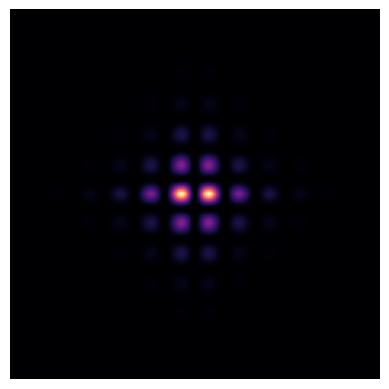

In [4]:
# Plot a test
kernel = kernel_fn(xv, yv)
plt.imshow(kernel.cpu().numpy(), cmap='magma')
plt.axis('off')
plt.show()

Now we can define the amplitude and scaling like we did in the 1D tutorial

In [5]:
amplitude_fn = lambda a, bs: bs[0]*torch.exp(-bs[1]*a)
sigma_fn = lambda a, bs: bs[0]*(a+0.1)
amplitude_params = torch.tensor([2,0.1], device=device, dtype=torch.float32)
sigma_params = torch.tensor([0.3], device=device, dtype=torch.float32)
# Define the kernel
kernel2D = FunctionalKernel2D(kernel_fn, amplitude_fn, sigma_fn, amplitude_params, sigma_params)

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


Let's evaluate the kernel at some distances:

In [6]:
a = torch.linspace(1,10,5).to(device)
kernel = kernel2D(xv, yv, a, normalize=True)

And we can plot and ensure they are normalized since we used `normalize=True`:

tensor([1.0073, 1.0005, 0.9592, 0.8743, 0.7737], device='cuda:0')


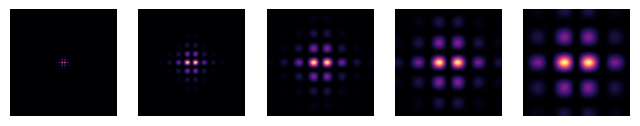

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(8,2))
print(kernel.sum(dim=(1,2)))
for i in range(5):
    ax[i].imshow(kernel[i].cpu().numpy(), cmap='magma')
    ax[i].axis('off')

# Other Kernels

There are other 2D kernels availalble.


## N-gon Kernel



 The kernel below represents the point spread function expected when SPECT data is acquired using a hexagonal collimator. It can be shown that the PSF is given by

$$\text{PSF} = \left[\beta \otimes \beta \right] \left[\frac{L_b}{L_b+a}\cdot (x,y) \right] $$

where $\beta$ is a 2D mask that represents the shape of the bore (i.e. a hexagon for a hexagonal collimator), $\otimes$ is the convolution operator, and $L_b$ is the length of the collimator holes. The `NGonKernel2D` class can be used to model $\beta \otimes \beta$.

In [8]:
collimator_length = 2.405 
collimator_width = 0.254 #flat side to flat side
sigma_fn = lambda a, bs: (bs[0]+a) / bs[0] 
sigma_params = torch.tensor([collimator_length], requires_grad=True, dtype=torch.float32, device=device)
# Set amplitude to 1
amplitude_fn = lambda a, bs: torch.ones_like(a)
amplitude_params = torch.tensor([1.], requires_grad=True, dtype=torch.float32, device=device)

ngon_kernel = NGonKernel2D(
    N_sides = 6, # sides of polygon
    Nx = 255, # resolution of polygon
    collimator_width=collimator_width, # width of polygon
    amplitude_fn=amplitude_fn,
    sigma_fn=sigma_fn,
    amplitude_params=amplitude_params,
    sigma_params=sigma_params,
    rot=90
)

Let's look at this kernel

In [9]:
Nx0 = 255
dx0 = 0.048
x = y = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
xv, yv = torch.meshgrid(x, y, indexing='xy')
distances = torch.tensor([1,5,10,15,20,25], dtype=torch.float32, device=device)
kernel = ngon_kernel(xv, yv, distances, normalize=True).cpu().detach()

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


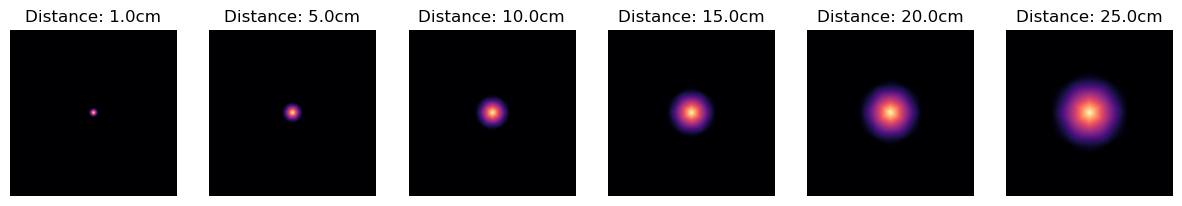

In [10]:
fig, ax = plt.subplots(1, 6, figsize=(15,3))
print(kernel.sum(dim=(1,2)))
for i in range(6):
    ax[i].set_title(f'Distance: {distances[i]}cm')
    ax[i].imshow(kernel[i], cmap='magma')
    ax[i].axis('off')